In [27]:
%load_ext autoreload
%autoreload 2


from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 99999999999999


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
x_data = Path('datasets/combo_001/lrup/')
y_data = Path('datasets/combo_001/hr')
y_tile = Path('datasets/tile_001/hr_t_512')
x_tile = Path('datasets/tile_001/lrup_t_512')



In [ ]:
def map2hr(x):
    return y_tile/x.relative_to(x_tile)

src = ImageImageList.from_folder(x_tile).split_by_folder().label_from_func(map2hr)

In [ ]:
src

In [ ]:
!ls /DATA/bpho_datasets/tile_001/hr_t_512/train/actin/0199

In [ ]:
tile_stuff.groupby('category').count()

In [ ]:
stats = file_data.groupby(['category','dims']).aggregate({'fsize': 'mean', 'name':'count'})
stats.columns = ['file_size', 'num']
stats

In [ ]:
files_by_cat = {}
for p in progress_bar(all_files):
    category = p.parts[-2]
    cat_list = files_by_cat.get(category, [])
    cat_list.append(p)
    files_by_cat[category] = cat_list

In [ ]:
def pull_random_tile_info(tile_sz):
    category=random.choice(list(files_by_cat.keys()))
    img_file=random.choice(files_by_cat[category])
    return {'category': category, 'fn': img_file, 'tile_sz': tile_sz}

In [ ]:
tile_sz = 1000
tile_infos = []
for i in range(1000):
    tile_infos.append(pull_random_tile_info(tile_sz))

In [ ]:
pd.DataFrame(tile_infos).groupby('category').count()

In [ ]:
from scipy.ndimage.interpolation import zoom as npzoom


def _micro_crappify(x, gauss_sigma = 1, poisson_loop=10, scale=4):
    x = x[0].numpy()
    x = x * 255.
    for n in range(poisson_loop):
        x = np.random.poisson(np.maximum(0,x).astype(np.int))
    x = x.astype(np.float32)
    noise = np.random.normal(0,gauss_sigma,size=x.shape).astype(np.float32)
    x = np.maximum(0,x+noise)
    x -= x.min()
    x /= x.max()
    return tensor(x[None])


class TfmEarly(Transform):
    "Decorator for pixel tfm funcs."
    order,_wrap = 0,'pixel'
micro_crappify = TfmEarly(_micro_crappify)




def get_src(x_data, y_data, size, zoom_scale=1.0, scale=1):
    def map_to_hr(x):
        return y_data/x.relative_to(x_data)
    tfms = [[],[]]
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    #tfms[0].insert(0, micro_crappify())
    
    src = (ImageImageList.from_folder(x_data)
           .split_by_folder()
           .label_from_func(map_to_hr)
           .transform(tfms, size=size)
           .transform_y(y_tfms, size=size*scale))
    return src


def get_data(src, **kwargs):
    data = src.databunch(**kwargs)
    data.c = 3
    return data


In [ ]:
src = get_src(x_data, y_data, size=128, zoom_scale=2, scale=1)
data = get_data(src, bs=4)
src

In [ ]:
model_dir = 'models'
arch = xresnet34
loss = F.l1_loss
metrics = sr_metrics
learn = xres_unet_learner(data, arch, path=Path('.'), loss_func=loss, metrics=metrics, model_dir=model_dir)


In [ ]:
learn.fit_one_cycle(1, 1e-4)

In [ ]:
import os

In [ ]:
all_files = []

for root,dirs,files in os.walk(y_data, topdown=False):
    all_files += files

In [ ]:
len(all_files)

In [193]:
img = PIL.Image.open('datasets/combo_001/hr/train/mitotracker/00_00_000001_MitoTracker Red FM 920x920 2min 01-Airyscan Processing-07.tif')

In [194]:
timg = Image(pil2tensor(img, dtype=np.float32))

In [195]:
#img = np.array(img)
#img.min(), img.max(), img.mean()/img.max(), img.std()/img.max()

In [200]:
%%timeit
from skimage.transform import rescale


def crappify(img, scale=4, upsample=True, pscale=12, gscale=0.0001):
    x = np.array(img)
    img_max = x.max()
    x = x.astype(np.float32)
    x /= float(img_max)
    
    x = rescale(x, scale=1/scale, order=1)

    x = np.random.poisson(x * pscale)/pscale
    x += np.random.normal(0, gscale, size=x.shape)
    x = np.maximum(0,x)
    x /= x.max()
    x *= img_max
    if upsample: x = rescale(x, scale=scale, order=0)
    return PIL.Image.fromarray(x.astype(np.uint8))

x = crappify(img)

26.2 ms ± 88.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


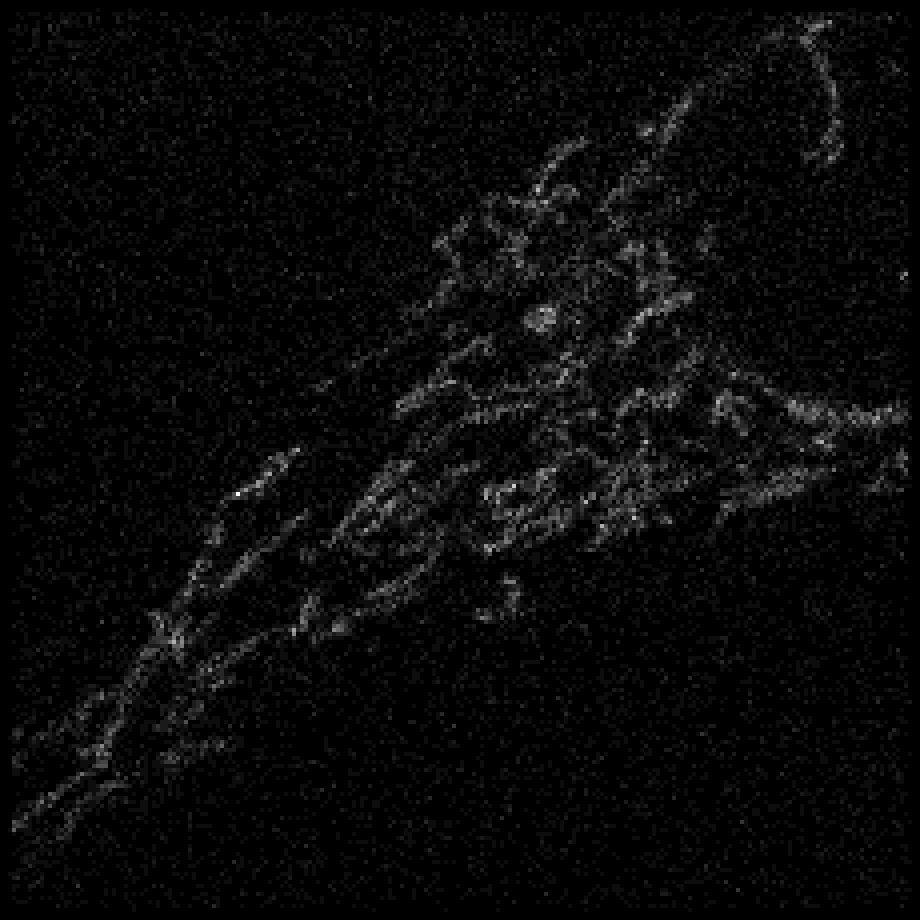

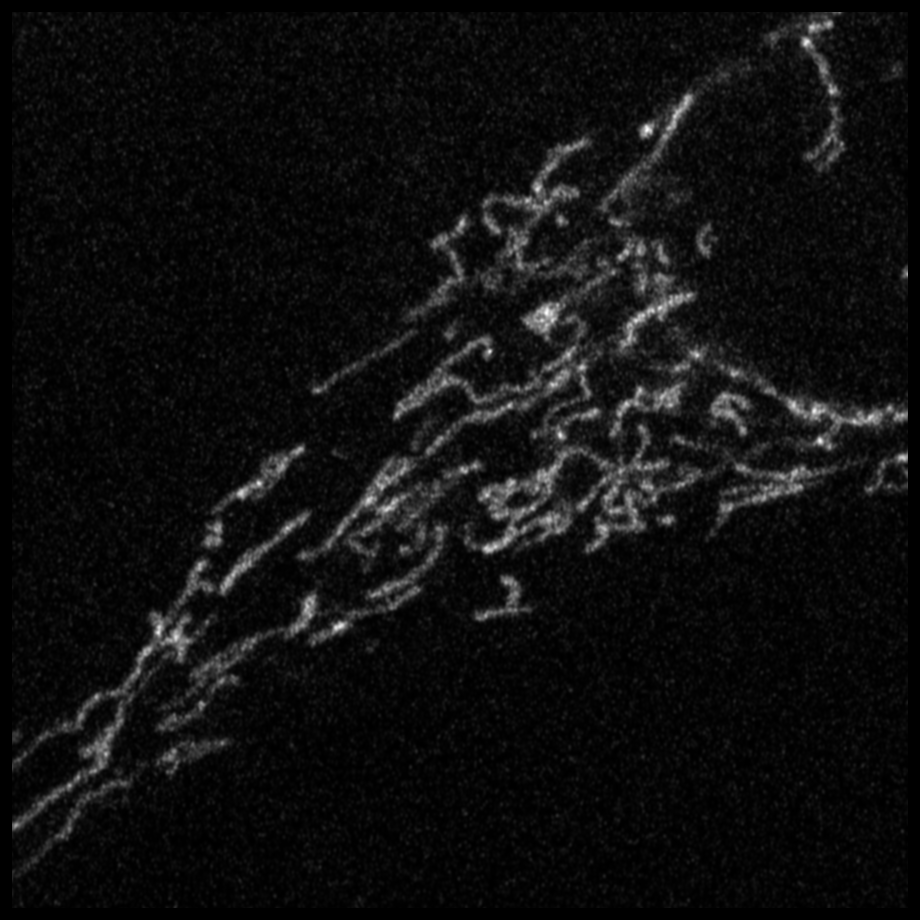

In [198]:
img